### 任务要求
- 统计2019年全年计算机各个方向论文数量（实际是19-20年）

### 数据集相关信息

- 数据集的格式如下：
    - `id`：arXiv ID，可用于访问论文；
    - `submitter`：论文提交者；
    - `authors`：论文作者；
    - `title`：论文标题；
    - `comments`：论文页数和图表等其他信息；
    - `journal-ref`：论文发表的期刊的信息；
    - `doi`：数字对象标识符，https://www.doi.org
    - `report-no`：报告编号；
    - `categories`：论文在 arXiv 系统的所属类别或标签；
    - `license`：文章的许可证；
    - `abstract`：论文摘要；
    - `versions`：论文版本；
    - `authors_parsed`：作者的信息。

（这里好像漏了个update_date）

### 导入库并配置绘图环境

In [1]:
#>============示例代码=============<
from bs4 import BeautifulSoup #用于爬取arxiv的数据
import re #用于正则表达式，匹配字符串的模式
import requests #用于网络连接，发送网络请求，使用域名获取对应信息
import json #读取数据，我们的数据为json格式的
import pandas as pd #数据处理，数据分析
import matplotlib.pyplot as plt #画图工具
import numpy as np
#>==============cHEn===============<
import sys
# 关于plt的一些配置
plt.style.use('seaborn')
dark_color = ['#e8ddcd','#cdb380','#036564','#033649','#031634']
light_color = ['#fe4365','#fc9d9a','#f9cdad','#c8c8a9','#83af9b']

### 导入数据

- 根据md文件的内容

In [2]:
data  = [] #初始化
#使用with语句优势：1.自动关闭文件句柄；2.自动显示（处理）文件读取数据异常
with open(r'..\arxiv-metadata-oai-snapshot.json', 'r') as f: 
    # 占用的内存太大了，这里只读入少量数据(500000/1796911)
    for idx,line in enumerate(f): 
        if idx>=500000:
            break
        
        data.append(json.loads(line))

- 根据ipynb文件的内容

这个方法比较好，可以灵活地选取需要的信息，读全所有数据也不会占太多内存

In [110]:
def readArxivFile(path, columns=['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 
                                 'doi','report-no', 'categories', 'license', 'abstract', 'versions',
                                 'update_date', 'authors_parsed'], count=None):
    '''
    定义读取文件的函数
        path: 文件路径
        columns: 需要选择的列
        count: 读取行数
    '''
    
    data  = []
    with open(path, 'r') as f: 
        for idx, line in enumerate(f): 
            if idx == count:
                break
                
            d = json.loads(line)
            # 按行读入json数据
            d = {col : d[col] for col in columns}
            # 字典推导式，改写字典dict的结构
            data.append(d)

#     data = pd.DataFrame(data)
    return data

data = readArxivFile(r'..\arxiv-metadata-oai-snapshot.json', ['id', 'categories', 'update_date'])

In [111]:
data = pd.DataFrame(data)
data.head()

,id,categories,update_date
0,0704.0001,hep-ph,2008-11-26
1,0704.0002,math.CO cs.CG,2008-12-13
2,0704.0003,physics.gen-ph,2008-01-13
3,0704.0004,math.CO,2007-05-23
4,0704.0005,math.CA math.FA,2013-10-15


### 数据预处理

#### categories
对论文的类别进行处理

In [17]:
data["categories"].describe()
# 学到了，describe方法对object类的输出。之前一直以为describe方法只能输出数值的mean、max、corr等信息

count      1796911
unique       62055
top       astro-ph
freq         86914
Name: categories, dtype: object

In [18]:
data["categories"].value_counts(ascending=False)
# 可以发现，有些论文的类别是多种类混合的，下面得到论文分类的种类

astro-ph                                                              86914
hep-ph                                                                73550
quant-ph                                                              53966
hep-th                                                                53287
cond-mat.mtrl-sci                                                     30107
                                                                      ...  
quant-ph cond-mat.mes-hall cs.CR cs.ET                                    1
q-bio.QM physics.chem-ph physics.comp-ph                                  1
cond-mat.supr-con cond-mat.mtrl-sci cond-mat.other physics.ins-det        1
quant-ph math.NA physics.atom-ph physics.chem-ph physics.comp-ph          1
cs.LG cs.DS math.OC stat.CO stat.ML                                       1
Name: categories, Length: 62055, dtype: int64

In [5]:
# 使用列表推导式将列表转为一维。示例代码的写法我理解起来有点吃力，且个人感觉可读性（变量名）不太好，就改写了一下
category_lst_lst = [category_lst.split(' ') for category_lst in data["categories"]]
unique_categories = set([category for category_lst in category_lst_lst for category in category_lst])
len(unique_categories)

# 由于只求cs方向，这里做了筛选
unique_cs_categories = [category for category in unique_categories if category.startswith('cs') ]
len(unique_cs_categories)

40

#### 筛出年份在2019年后的论文

In [6]:
data["year"] = pd.to_datetime(data["update_date"]).dt.year
# 使用Pandas的dt接口（第一次接触到）得到年份信息，我之前都是用apply来使用字符串切片操作取年份的，学习了
del data["update_date"] 
data = data[data["year"] >= 2019]

In [7]:
data = data.reset_index(drop=True)
# 因为之前做了取部分数据的操作，需要重设index
data

,id,categories,year
0,0704.0297,astro-ph,2019
1,0704.0342,math.AT,2019
2,0704.0360,astro-ph,2019
3,0704.0525,gr-qc,2019
4,0704.0535,astro-ph,2019
...,...,...,...
395118,quant-ph/9911051,quant-ph,2020
395119,solv-int/9511005,solv-int nlin.SI,2019
395120,solv-int/9809008,solv-int nlin.SI,2019
395121,solv-int/9909010,solv-int adap-org hep-th nlin.AO nlin.SI,2019


#### 爬取所有类别
该部分使用爬虫爬取数据。爬虫的内容还未接触，但最近期末，也没时间去了解爬虫包括正则表达式（Linux里有所接触），日后再补。

In [8]:
#爬取所有的类别
website_url = requests.get('https://arxiv.org/category_taxonomy').text #获取网页的文本数据
soup = BeautifulSoup(website_url,'lxml') #爬取数据，这里使用lxml的解析器，加速
root = soup.find('div',{'id':'category_taxonomy_list'}) #找出 BeautifulSoup 对应的标签入口
tags = root.find_all(["h2","h3","h4","p"], recursive=True) #读取 tags

In [9]:
#初始化 str 和 list 变量
level_1_name = ""
level_2_name = ""
level_2_code = ""
level_1_names = []
level_2_codes = []
level_2_names = []
level_3_codes = []
level_3_names = []
level_3_notes = []

In [10]:
#进行
for t in tags:
    if t.name == "h2":
        level_1_name = t.text    
        level_2_code = t.text
        level_2_name = t.text
    elif t.name == "h3":
        raw = t.text
        level_2_code = re.sub(r"(.*)\((.*)\)",r"\2",raw) #正则表达式：模式字符串：(.*)\((.*)\)；被替换字符串"\2"；被处理字符串：raw
        level_2_name = re.sub(r"(.*)\((.*)\)",r"\1",raw)
    elif t.name == "h4":
        raw = t.text
        level_3_code = re.sub(r"(.*) \((.*)\)",r"\1",raw)
        level_3_name = re.sub(r"(.*) \((.*)\)",r"\2",raw)
    elif t.name == "p":
        notes = t.text
        level_1_names.append(level_1_name)
        level_2_names.append(level_2_name)
        level_2_codes.append(level_2_code)
        level_3_names.append(level_3_name)
        level_3_codes.append(level_3_code)
        level_3_notes.append(notes)

In [11]:
#根据以上信息生成dataframe格式的数据
df_taxonomy = pd.DataFrame({
                            'group_name' : level_1_names,
                            'archive_name' : level_2_names,
                            'archive_id' : level_2_codes,
                            'category_name' : level_3_names,
                            'categories' : level_3_codes,
                            'category_description': level_3_notes
                            })

In [12]:
#按照 "group_name" 进行分组，在组内使用 "archive_name" 进行排序
df_taxonomy.groupby(["group_name","archive_name"])
df_taxonomy

,group_name,archive_name,archive_id,category_name,categories,category_description
0,Computer Science,Computer Science,Computer Science,Artificial Intelligence,cs.AI,"Covers all areas of AI except Vision, Robotics..."
1,Computer Science,Computer Science,Computer Science,Hardware Architecture,cs.AR,Covers systems organization and hardware archi...
2,Computer Science,Computer Science,Computer Science,Computational Complexity,cs.CC,"Covers models of computation, complexity class..."
3,Computer Science,Computer Science,Computer Science,"Computational Engineering, Finance, and Science",cs.CE,Covers applications of computer science to the...
4,Computer Science,Computer Science,Computer Science,Computational Geometry,cs.CG,Roughly includes material in ACM Subject Class...
...,...,...,...,...,...,...
150,Statistics,Statistics,Statistics,Computation,stat.CO,"Algorithms, Simulation, Visualization"
151,Statistics,Statistics,Statistics,Methodology,stat.ME,"Design, Surveys, Model Selection, Multiple Tes..."
152,Statistics,Statistics,Statistics,Machine Learning,stat.ML,"Covers machine learning papers (supervised, un..."
153,Statistics,Statistics,Statistics,Other Statistics,stat.OT,Work in statistics that does not fit into the ...


**疑问-1：**

为什么这里的种类比前面的unique_categories还少？

In [48]:
# 求证过程：
missing_lst = []
for category in unique_categories:
    if category in list(df_taxonomy['categories'].unique()):
        continue
    else:
        missing_lst.append(category)
missing_lst

['astro-ph',
 'chem-ph',
 'bayes-an',
 'solv-int',
 'ao-sci',
 'q-bio',
 'q-alg',
 'funct-an',
 'adap-org',
 'dg-ga',
 'acc-phys',
 'chao-dyn',
 'alg-geom',
 'atom-ph',
 'comp-gas',
 'plasm-ph',
 'mtrl-th',
 'patt-sol',
 'supr-con',
 'cond-mat',
 'cmp-lg']

**发现：**

缺失的部分其实是类名，应该是在爬虫部分省略了

**衍生出来的疑问-2：**

unique_categories里已经有类别数据了，为什么要爬取得到呢？如果说要全称，我觉得完全可以用字典映射来实现；如果说要group_name，也可用startwith来处理（规律很统一）

### 数据分析

#### 示例代码：

In [113]:

_df = data.merge(df_taxonomy, on="categories", how="left").drop_duplicates(["id","group_name"]).groupby("group_name").agg({"id":"count"}).sort_values(by="id",ascending=False).reset_index()
_df['id'].sum() # 182366

_df

,group_name,id
0,Physics,564423
1,Mathematics,217136
2,Computer Science,116539
3,Statistics,13459
4,Quantitative Biology,9022
5,Electrical Engineering and Systems Science,4464
6,Quantitative Finance,3116
7,Economics,724


#### 我的处理：接**疑问-2**

In [ ]:
# 统计
def getGroupName(string): return string.split('.')[0]
# 这里的category_lst和category_lst_lst是之前生成的
category_lst = [getGroupName(string) for string in [category for category_lst in category_lst_lst for category in category_lst]]
s = set(category_lst)
d = {category:0 for category in s}

# d = {category:d.get(category)+1 for category_lst in category_lst_lst for category in category_lst}
# 错误做法，运算时先进行字典推导再进行赋值操作，所以不能达到值的累加的目的

# 使用二重循环实现出现次数的统计
for category in category_lst:
    d[category] = d.get(category,0)+1

In [ ]:
# 转化为能够转换为DataFrame的形式(第一次尝试这种转换，没有什么好的想法)
toDataframeCountLst = []
for k,v in d.items():
    toDataframeCountLst.append(eval('{'+"'groupname':'{}','mapname':{}".format(k,v)+'}'))

In [ ]:
# 建立groupname的字典映射
nameMap = {'cs':'Computer Science',
           'econ':'Economics',
           'eess':'Electrical Engineering and Systems Science',
           'math':'Mathematics',
           'astro-ph':'Physics',
           'cond-mat':'Physics',
           'gr-qc':'Physics',
           'hep-ex':'Physics',
           'hep-lat':'Physics',
           'hep-ph':'Physics',
           'hep-th':'Physics',
           'math-ph':'Physics',
           'nlin':'Physics',
           'nucl-ex':'Physics',
           'nucl-th':'Physics',
           'physics':'Physics',
           'quant-ph':'Physics',
           'q-fin':'Quantitative Finance',
           'stat':'Statistics'}

In [ ]:
# 转换为dataframe，并做groupname的转换
CountDataframe = pd.DataFrame(toDataframeCountLst)
CountDataframe['groupname'] = CountDataframe['groupname'].map(nameMap)

In [121]:
# 合并数据，得到结果
CountDataframe = CountDataframe[CountDataframe['groupname'].notnull()].groupby(by='groupname').sum().\
                 sort_values(by='mapname',ascending=False).reset_index()
CountDataframe

,groupname,mapname
0,Physics,1657286
1,Mathematics,652409
2,Computer Science,441894
3,Statistics,94838
4,Electrical Engineering and Systems Science,29440
5,Quantitative Finance,15033
6,Economics,3236


**疑问：**好像数据上差别比较大？

示例代码总共只有18万，这里是全部数据

### 数据可视化

#### 示例代码：

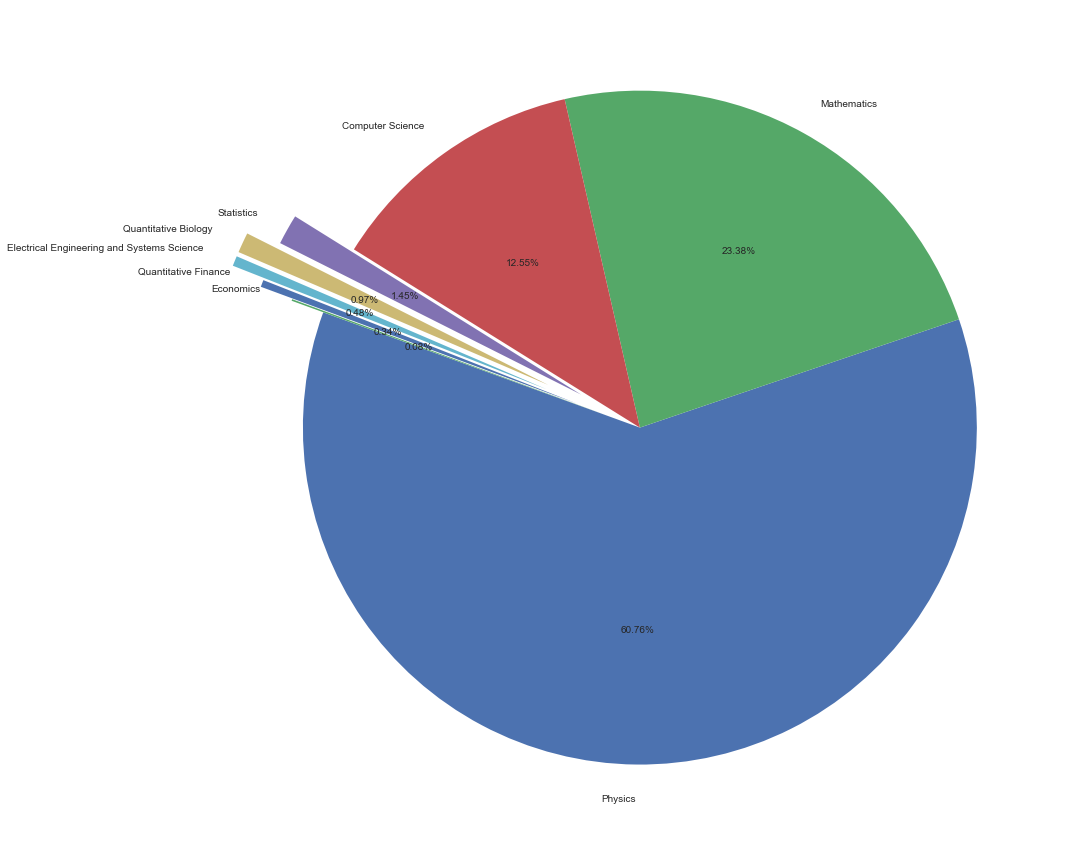

In [130]:
fig = plt.figure(figsize=(15,12))
explode = (0, 0, 0, 0.2, 0.3, 0.3, 0.2, 0.1) 
plt.pie(_df["id"],  labels=_df["group_name"], autopct='%1.2f%%', startangle=160, explode=explode)
plt.tight_layout()
plt.show()

#### cHEn

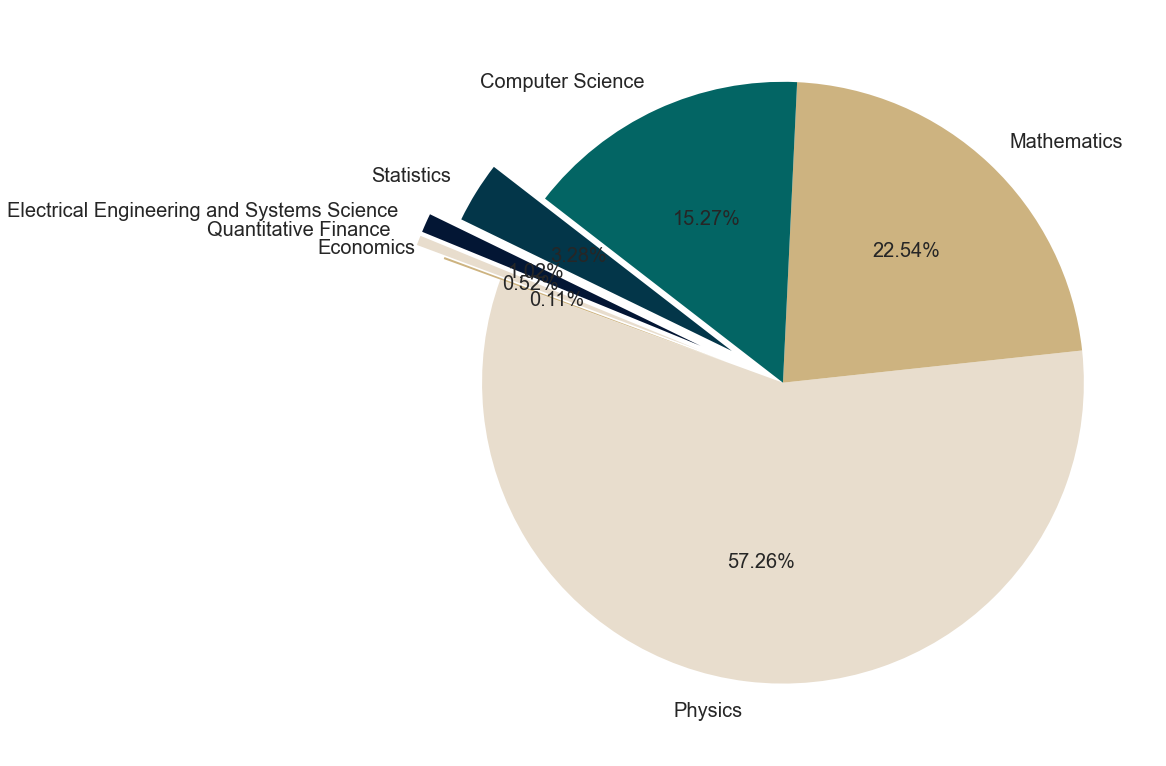

In [138]:
fig = plt.figure(figsize=(15,12))
explode = (0, 0, 0, 0.2, 0.3, 0.3, 0.2) 
patches,l_text,p_text = plt.pie(CountDataframe['mapname'],labels=CountDataframe["groupname"],autopct='%1.2f%%', \
                                startangle=160, colors=dark_color, explode=explode)
# 循环调整字体大小
for t in l_text:
    t.set_size(20)
for t in p_text:
    t.set_size(20)

plt.tight_layout()
plt.show()


相关笔记可以前往：

https://github.com/chenjiyan2001/Datawhale-2021.1-team-learning-AcademicTrends/tree/main/%E7%AC%94%E8%AE%B0